###**0. Imports e connect à Google Drive**

In [2]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import re
from PIL import Image
import cv2
import copy
import zipfile
import gdown
import albumentations as A
import random
import datetime
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
# correr esta célula apenas se o dataset estiver na drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Este pedaço de código é destinado a aceder à pasta do dataset, portanto pode ser diferente de user para user
%cd /content/drive/MyDrive/Mars_Capstone_Project/train_data_JBL

/content/drive/MyDrive/Mars_Capstone_Project/train_data_JBL


##**Importar as imagens que vão servir de base para o treino e validação dos dois modelos**

In [8]:
def create_X(img_path):

    path = os.path.join(root_img, img_path)
    img_arr = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_arr = cv2.resize(img_arr,(512,360))
    #img_normalized = cv2.normalize(img_arr, None, -1, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    return img_arr

In [6]:
def create_y(bbox_path):

    path = os.path.join(root_bbox, bbox_path)
    f = open(path, 'r')
    lines = f.readlines()
    coordinates = lines[0].split(' ')
    bbox = [float(coordinate) for coordinate in coordinates]
    bbox.remove(0)
    f.close()

    return bbox

In [9]:
y_set = []
X_set = []

root_bbox = './labels/labels_colunajbl_objectdetection_2023-08-29-07-35-33'
root_img = './images/Imagens_ColunaJBL'

files_bbox = os.listdir(root_bbox)
files_img = os.listdir(root_img)

for bbox_path in files_bbox:

    img_number1 = bbox_path.split('.')[0]

    for img_path in files_img:

        img_number2 = img_path.split('.')[0]

        if img_number1 == img_number2:

          y = create_y(bbox_path)
          y_set.append(y)

          X = create_X(img_path)
          X_set.append(X)

y_set = np.array(y_set)
X_set = np.array(X_set)

In [10]:
y_set[0]

array([0.392361, 0.404297, 0.072917, 0.097656])

In [11]:
y_set.shape

(102, 4)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_set, y_set, train_size=0.8, test_size=0.2, shuffle=False, random_state = 42)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(81, 360, 512) (21, 360, 512)
(81, 4) (21, 4)


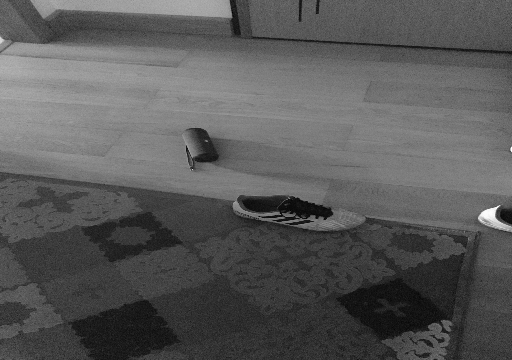

In [13]:
X = X_train[0]
x = cv2.merge([X, X, X])
pil_img = tf.keras.utils.array_to_img(x)
pil_img

In [14]:
# esta função também pode servir para mostrar uma imagem sem bounding box, basta colocar bbox = []

def show_image_bbox(X_arr, y_arr, new_img_path):

  y_arr_albu = [0,0,0,0]

  if len(y_arr) != 0:
    y_arr_albu[0] = y_arr[0] - y_arr[2] / 2
    y_arr_albu[1] = y_arr[1] - y_arr[3] / 2
    y_arr_albu[2] = y_arr[2] + y_arr_albu[0]
    y_arr_albu[3] = y_arr[3] + y_arr_albu[1]


  # os valores da bbox têm de entrar normalizados
  shape_after = X_arr.shape

  X_arr = cv2.merge([X_arr, X_arr, X_arr])   # para conseguir visualizar uma imagem a cinzento

  bbox_ = copy.deepcopy(y_arr_albu)
  pil_img = tf.keras.utils.array_to_img(X_arr)  # esta função tira a normalização do array (não tem muito problema dado que esta função é apenas para demonstração, no modelo entram os valores normalizados)

  tf.keras.utils.save_img(new_img_path, pil_img)

  if len(bbox_) != 0:
    bbox_[0] *= shape_after[1]
    bbox_[1] *= shape_after[0]
    bbox_[2] *= shape_after[1]
    bbox_[3] *= shape_after[0]

    start_point = (int(bbox_[0]), int(bbox_[1]))
    end_point = (int(bbox_[2]), int(bbox_[3]))

  color = (255,0,0)  # RGB, fica vermelho desta forma
  thickness = 1

  image = cv2.imread('./' + new_img_path)

  if len(bbox_) != 0:
    image = cv2.rectangle(image, start_point, end_point, color, thickness)  # tem de se usar valores inteiros aqui
    image = cv2.putText(image, 'sample', (int(bbox_[0]), int(bbox_[1] - 3)), 0, 0.3, (255,0,0), 1)

  final_img = tf.keras.utils.array_to_img(image)

  return final_img

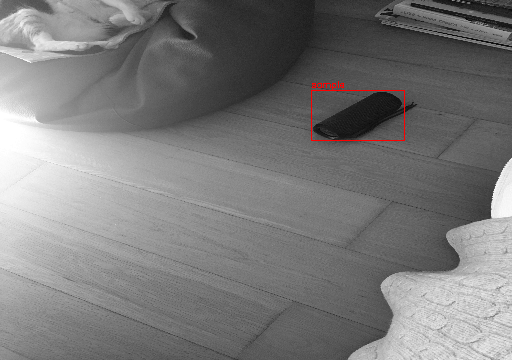

In [15]:
index = 3
show_image_bbox(X_train[index], y_train[index], 'coluna.png')

##**Callbacks: ModelCheckoint, CSVLogger, TensorBoard**

In [13]:
!mkdir callbacks
!mkdir ./callbacks/tensorboard
!mkdir ./callbacks/checkpoints

mkdir: cannot create directory ‘callbacks’: File exists
mkdir: cannot create directory ‘./callbacks/tensorboard’: File exists
mkdir: cannot create directory ‘./callbacks/checkpoints’: File exists


In [14]:
# preparar o CSVLogger callback object

logger_path = './callbacks/graytraining_logger' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S') + '.log'  # tem gray na path do file para diferenciar
csv_logger = CSVLogger(logger_path,
                       append=True,
                       separator=',')

In [15]:
# preparar o ModelCheckpoint callback object

checkpoint_path = './callbacks/checkpoints/grayCkpt1_{epoch:02d}_{val_loss:.05f}_.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

In [16]:
# preparar o TensorBoard callback object

%load_ext tensorboard

tboard_path = './callbacks/tensorboard/gray_' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard = TensorBoard(log_dir = tboard_path,
                          histogram_freq=1)

##**Preprocessing para modelo de regressão**

In [16]:
X_train.shape

(81, 360, 512)

In [17]:
def resize_img(X_set):

  X = []
  for arr in X_set:
      X.append(cv2.resize(arr,(512,384)))

  return np.array(X)

In [18]:
X_train_regres = resize_img(X_train)
X_val_regres = resize_img(X_train)

In [19]:
X_train_regres.shape, X_val_regres.shape

((81, 384, 512), (81, 384, 512))

In [20]:
def transform_images(X_set, bbox_set, transform):

    bbox_set = list(bbox_set)
    X_transformed = []
    bbox_transformed = []

    for i in range(len(bbox_set)):

        bbox_set[i] = list(bbox_set[i])
        bbox_set[i].append('sample')

    for i in range(X_set.shape[0]):

        transformed = transform(image=X_set[i], bboxes=[bbox_set[i]])
        transformed_image = transformed['image']
        transformed_bbox = transformed['bboxes']

        X_transformed.append(transformed_image)
        bbox_transformed.append(transformed_bbox)

    for i in range(len(bbox_transformed)):

        if len(bbox_transformed[i]) != 0:
          bbox_transformed[i] = list(bbox_transformed[i][0])
          bbox_transformed[i].remove('sample')

    # retirar as imagens onde o tubo não está presente

    X_train_transf = []
    y_train_transf = []

    for i, bbox in enumerate(bbox_transformed):

        if len(bbox) != 0:
          X_train_transf.append(X_transformed[i])
          y_train_transf.append(bbox)

    return np.array(X_train_transf), np.array(y_train_transf)

In [21]:
# efetuamos três transformações diferentes em todo o X_train e y_train
# no final, fazemos concat dos novos elementos de X_train e y_train

def transformations_and_concat(X_set, y_set):

    reshape_values = (X_set.shape[1], X_set.shape[2])

    random.seed(42)
    transform_1 = A.Compose([A.augmentations.transforms.Solarize(
                             threshold=0.4, p=1),
                             ],
                             bbox_params=A.BboxParams(format='yolo'))

    random.seed(42)
    transform_2 = A.Compose([A.augmentations.transforms.Superpixels(
                             p_replace=0.1, n_segments=100, max_size=500, p=1)
                             ],
                             bbox_params=A.BboxParams(format='yolo'))

    transformed_X_set_1, transformed_y_set_1 = transform_images(X_set, y_set, transform_1)
    transformed_X_set_2, transformed_y_set_2 = transform_images(X_set, y_set, transform_2)


    # para conseguir este concat, é necessário terem todas as mesma shape que X_set

    X_set_final1 = np.concatenate([X_set,
                                  transformed_X_set_1,
                                  transformed_X_set_2,
                                  ])

    y_set_final1 = np.concatenate([y_set,
                                  transformed_y_set_1,
                                  transformed_y_set_2,
                                  ])



    # aplicar random crop a todas as transformações feitas

    random.seed(42)
    transform_3 = A.Compose([A.RandomCrop(width=192, height=144),
                             A.augmentations.geometric.resize.Resize(
                             height = reshape_values[0], width = reshape_values[1]),
                             A.augmentations.geometric.transforms.Affine(scale=1.5, p=1),
                             ],
                             bbox_params=A.BboxParams(format='yolo'))



    transformed_X_final1, transformed_y_final1 = transform_images(
    X_set_final1, y_set_final1, transform_3)


    X_set_final2 = np.concatenate([X_set_final1,
                                   transformed_X_final1])

    y_set_final2 = np.concatenate([y_set_final1,
                                   transformed_y_final1])

    return np.array(X_set_final2), np.array(y_set_final2)

In [22]:
X_train_regression, y_train_regression = transformations_and_concat(X_train, y_train)
X_val_regression, y_val_regression = X_val, y_val

print(X_train_regression.shape, y_train_regression.shape,
      X_val_regression.shape, y_val_regression.shape)

(328, 360, 512) (328, 4) (21, 360, 512) (21, 4)


##**Modelo de regressão**

In [104]:
_, height, width = X_train_regression.shape
model_regression = Sequential([

    Conv2D(filters=16,kernel_size=(3,3), input_shape = (height, width, 1), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),

    Dense(4, activation='sigmoid')
])


model_regression.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 358, 510, 16)      160       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 179, 255, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 177, 253, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 88, 126, 32)      0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 88, 126, 32)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 86, 124, 64)      

In [109]:
model_regression.compile(optimizer=Adam(learning_rate=0.001),
                         loss=tf.keras.losses.MeanSquaredError(),
                         metrics=['accuracy'])

In [ ]:
model_regression.fit(X_train_regression,
                     y_train_regression,
                     epochs = 20,
                     batch_size = 15,
                     validation_data = (X_val_regression, y_val_regression),
                     callbacks = [checkpoint, csv_logger, tensorboard])

In [90]:
#model_regression.load_weights('./callbacks/checkpoints/grayCkpt1_01_0.15065_.h5')

##**Preprocessing para o modelo de deteção**

In [23]:
# esta função executa o contrário da anterior: transforma uma bounding box com
# coordenadas em formato YOLO para uma bounding box em formato Albu

def bboxYOLO_to_Albu(y_set):

    y_Albu = []

    for bbox in y_set:

        vector = [0,0,0,0]

        vector[0] = bbox[0] - bbox[2] / 2
        vector[1] = bbox[1] - bbox[3] / 2
        vector[2] = bbox[2] + vector[0]
        vector[3] = bbox[3] + vector[1]

        y_Albu.append(vector)

    return np.array(y_Albu)

In [24]:
# this function takes the images from X_train and X_val as input, as well as
# the bounding box coordinates for the sample and
# returns the same images but without the sample

def erase_sample(X_set, y_set):

    X_set_erased_sample = []
    y_set_erased_sample = []

    y_set_albu = bboxYOLO_to_Albu(y_set)
    current_shape = X_set[0].shape

    for i, bbox in enumerate(y_set_albu):

        mask = np.zeros(current_shape, dtype=np.uint8)

        bbox_ = copy.deepcopy(bbox)
        bbox_[0] *= current_shape[1]
        bbox_[1] *= current_shape[0]
        bbox_[2] *= current_shape[1]
        bbox_[3] *= current_shape[0]

        x_points = (int(bbox_[0]), int(bbox_[2]))
        y_points = (int(bbox_[1]), int(bbox_[3]))

        mask[y_points[0]:y_points[1], x_points[0]:x_points[1]] = 255
        masked_image = cv2.bitwise_and(X_set[i], X_set[i], mask = mask)
        X_set_erased_sample.append(cv2.inpaint(X_set[i], masked_image, 3, cv2.INPAINT_TELEA))

        y_set_erased_sample.append([0.5, 0.5, 1, 1])

    return np.array(X_set_erased_sample), np.array(y_set_erased_sample)

In [25]:
X_train_erased_sample, y_train_erased_sample = erase_sample(X_train, y_train)
X_val_erased_sample, y_val_erased_sample = erase_sample(X_val, y_val)

In [26]:
print(X_train_erased_sample.shape, y_train_erased_sample.shape,
      X_val_erased_sample.shape, y_val_erased_sample.shape)

(81, 360, 512) (81, 4) (21, 360, 512) (21, 4)


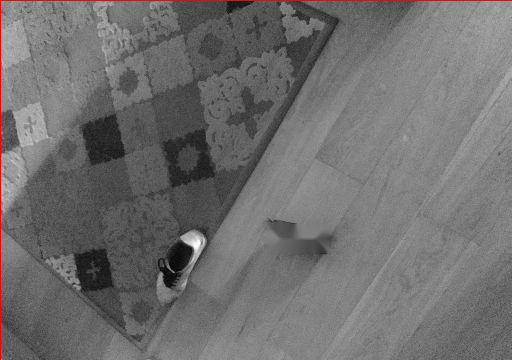

In [27]:
show_image_bbox(X_train_erased_sample[6], y_train_erased_sample[6], 'show.png')

In [28]:
# efetuamos apenas um zoom e crop nestas imagens sem tubo e no final damos
# concat dessas novas imagens com as originais sem tubo

def crop_zoom_transformations_and_concat(X_set, y_set):

    reshape_values = (X_set.shape[1], X_set.shape[2])

    random.seed(42)
    transform_1 = A.Compose([A.RandomCrop(width=192, height=144),
                             A.augmentations.geometric.resize.Resize(
                             height = reshape_values[0], width = reshape_values[1]),
                             A.augmentations.geometric.transforms.Affine(scale=1.5, p=1),
                             ],
                             bbox_params=A.BboxParams(format='yolo'))

    transformed_X_set, transformed_y_set = transform_images(X_set, y_set, transform_1)


    # para conseguir este concat, é necessário terem todas as mesma shape que X_set

    X_set_final = np.concatenate([X_set, transformed_X_set])
    y_set_final = np.concatenate([y_set, transformed_y_set])

    return np.array(X_set_final), y_set_final

In [29]:
### 1st part (train sets) ###

# applying the transformations to X_train_erased_sample
X_train_erased, _ = crop_zoom_transformations_and_concat(X_train_erased_sample,
                                                         y_train_erased_sample)

# applying the transformations to X_train and y_train
X_train_not_erased, y_train_not_erased = crop_zoom_transformations_and_concat(X_train, y_train)


# changing the bbox values of X_train_erased_sample images to NaN
y_train_null = []
for i in range(len(X_train_erased)):
    y_train_null.append([np.nan] * 4)
y_train_erased = np.array(y_train_null)


# creating X_train_detection and y_train_detection
X_train_detection = np.concatenate([X_train_not_erased, X_train_erased])
y_train_detection = np.concatenate([y_train_not_erased, y_train_erased])


### 2nd part (validation sets) ###

# changing the bbox values of X_val_erased_sample images to NaN
y_train_null = []
for i in range(len(X_val_erased_sample)):
    y_train_null.append([np.nan] * 4)
y_val_erased = np.array(y_train_null)


# creating X_val_detection and y_val_detection
X_val_detection = np.concatenate([X_val, X_val_erased_sample])
y_val_detection = np.concatenate([y_val, y_val_erased])

print(X_train_detection.shape, y_train_detection.shape,
      X_val_detection.shape, y_val_detection.shape)

(273, 360, 512) (273, 4) (42, 360, 512) (42, 4)


In [30]:
def prepare_y_set_detection(y_set):

    y = []
    for bbox in y_set:

        if np.isnan(bbox[0]):
          y.append([1,0])  # [1,0] representa 0, ou seja, o tubo não está presente

        else:
          y.append([0,1])

    return np.array(y)

In [31]:
y_train_det = prepare_y_set_detection(y_train_detection)
y_val_det = prepare_y_set_detection(y_val_detection)

print(y_train_det.shape, y_val_det.shape)

(273, 2) (42, 2)


In [32]:
# this function will provide a direct understandemnet of the y set:
# if the element is 0, there is no sample in the image;
# if the element is 1, the sample is in the image
# it will store the confidence for each prediction made

def zerosones_and_confidence(y_set):

    y_zeros_ones = []
    confidence_values = []

    for y in y_set:

      confidence = round(y[1], 1)
      confidence_values.append(confidence)  # arredona a 1 casa decimal

      if confidence < 0.5:
        y_zeros_ones.append(0)

      else:
        y_zeros_ones.append(1)

    return np.array(y_zeros_ones), np.array(confidence_values)

In [33]:
y_val_01, _ = zerosones_and_confidence(y_val_det)

In [34]:
y_val_01.shape, y_val_det.shape

((42,), (42, 2))

In [35]:
y_val_01

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

##**Modelo de deteção**

In [40]:
_, height, width = X_train_detection.shape

model_detection = Sequential([

    Conv2D(filters=64, kernel_size=(3,3), input_shape=(360, 512, 1), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"),
    Dropout(0.1),

    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"),
    Dropout(0.1),

    Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"),
    Dropout(0.1),

    Flatten(),
    Dense(128, activation='relu'),

    Dense(2, activation='softmax')
])

model_detection.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 358, 510, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 179, 255, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 179, 255, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 177, 253, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 88, 126, 32)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 88, 126, 32)       0

In [41]:
model_detection.compile(optimizer=Adam(learning_rate=0.001),
                        loss= 'binary_crossentropy',
                        metrics=['accuracy'])

In [42]:
model_detection.fit(X_train_detection,
                    y_train_det,
                    epochs = 30,
                    batch_size = 32,
                    validation_data = (X_val_detection, y_val_det),
                    callbacks = [checkpoint, csv_logger, tensorboard])

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 126.3110 - accuracy: 0.4432 
Epoch 1: val_loss improved from inf to 0.69601, saving model to ./callbacks/checkpoints/grayCkpt1_01_0.69601_.h5
9/9 [==============================] - 177s 18s/step - loss: 126.3110 - accuracy: 0.4432 - val_loss: 0.6960 - val_accuracy: 0.5000
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.5824 
Epoch 2: val_loss improved from 0.69601 to 0.69340, saving model to ./callbacks/checkpoints/grayCkpt1_02_0.69340_.h5
9/9 [==============================] - 150s 17s/step - loss: 0.7090 - accuracy: 0.5824 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5934 
Epoch 3: val_loss improved from 0.69340 to 0.69319, saving model to ./callbacks/checkpoints/grayCkpt1_03_0.69319_.h5
9/9 [==============================] - 149s 17s/step - loss: 0.6931 - accuracy: 0.5934 - val_loss: 0.6932 - val_

KeyboardInterrupt: ignored

In [ ]:
#model_detection.load_weights('grayCkpt1_13_0.68606_.h5') # este é para o tubo

#**DISCLAIMER**: Uma vez que as estruturas dos modelos estagnaram ao treinar com estas imagens, o que se segue não foi atualizado, pois caso funcionasse, as predictions teriam a mesma estrutura que o nosso modelo de PREDICTIONS.

##**Pipeline de predictions**

In [ ]:
model_detection.load_weights('')
model_regression.load_weights('')

In [57]:
def intersection_over_union(bboxA, bboxB):

    if np.isnan(bboxA[0]) or np.isnan(bboxB[0]):
      return 0

    bboxes = bboxYOLO_to_Albu([bboxA, bboxB])
    bbox1 = bboxes[0]
    bbox2 = bboxes[1]

    # bbox = [xmin, ymin, xmax, ymax]
    xmin = max(bbox1[0], bbox2[0])
    ymin = max(bbox1[1], bbox2[1])
    xmax = min(bbox1[2], bbox2[2])
    ymax = min(bbox1[3], bbox2[3])

    intersection_width = xmax - xmin
    intersection_height = ymax - ymin

    if intersection_width <= 0 or intersection_height <= 0:
      return 0

    intersection_area = intersection_width * intersection_height

    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

    union_area = bbox1_area + bbox2_area - intersection_area

    IoU = round(intersection_area / union_area, 2)  # arredondado?

    return IoU

In [87]:
def iou_info(y_set, y_pred):

  iou_sum = 0
  iou_above_50 = []

  for i in range(len(y_set)):
      iou = intersection_over_union(y_set[i], y_pred[i])

      if iou > 0:
        iou_above_50.append(i)
        iou_sum += iou

  pct_iou_mean = iou_sum / len(iou_above_50) * 100
  pct_intersection = len(iou_above_50) / y_set.shape[0] * 100

  return pct_iou_mean, len(iou_above_50), pct_intersection, iou_above_50

In [ ]:
y_pred_detection = model_detection.predict(X_val)

In [ ]:
# só são considerados positivos pela deteção aqueles cuja confidence é igual ou superior a 0.3
# só serão considerados True Positives pela regressão aqueles cuja IoU é igual ou superior a 0.3
# e falsos positivos se for inferior

X_val_positives = []
indexes_positives = []
y_pred_01 = []
confidence_scores = []

for i, y in enumerate(y_pred_detection):

    confidence = round(y[1], 1)
    confidence_scores.append(confidence)

    if confidence >= 0.3:  # trocar aqui o sinal
      indexes_positives.append(i)
      X_val_positives.append(X_val[i])
      y_pred_01.append(1)

    else:
      y_pred_01.append(0)

X_val_positives = np.array(X_val_positives)
y_pred_01 = np.array(y_pred_01)
y_pred_01

In [ ]:
y_pred_regression = model_regression.predict(X_val_positives)

In [ ]:
# com o threshold dado por nós para o IoU, atualiza-se o
# y_pred_01 para y_pred_01_new

y_pred_01_new = copy.deepcopy(y_pred_01)
for y in y_pred_regression:

    for index in indexes_positives:

      if intersection_over_union(y, y_val_regression[index]) < 0.3:
        y_pred_01_new[index] = 0

In [ ]:
y_pred_01_new

###**Metrics**

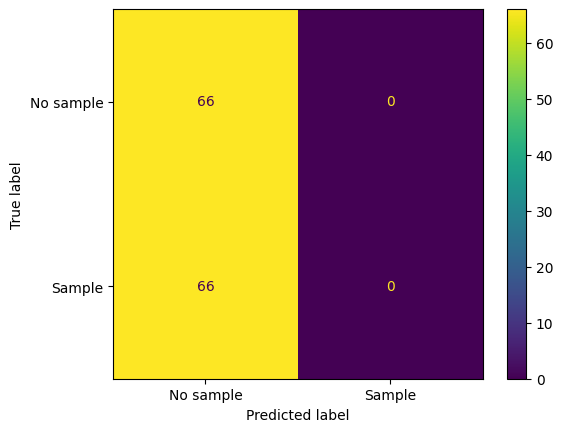

In [ ]:
# plotting the Confusion Matrix
cm = metrics.confusion_matrix(y_val_01, y_pred_01_new)
cm_plt = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No sample', 'Sample'])
cm_plt.plot()
plt.show()

In [ ]:
# True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN)
# to calculate precision, recall and f1 score
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = TP / (TP + 0.5 * (FP + FN))

print(precision, recall, f1_score)

nan 0.0 0.0


<ipython-input-33-38be5497f7a6>:8: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP / (TP + FP)


In [ ]:
y_pred = model_regression.predict(X_val_regression)

print(' - for y_val and y_pred:'
      '\n mean % of the area intersected in all (good) intersections:', iou_info(y_val_regression, y_pred)[0],
      '\n number of (good) intersections:', iou_info(y_val_regression, y_pred)[1],
      '\n percentage of (good) intersections:', iou_info(y_val_regression, y_pred)[2],
      '\n indexes of images with (good) intersections:', iou_info(y_val_regression, y_pred)[3])

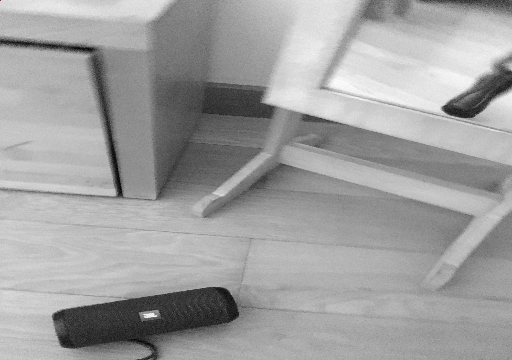

In [94]:
show_image_bbox(X_val_regression[0], y_pred[0], 'oo.png')

##**YOLO com este modelo**

In [ ]:
!mkdir ./train
!mkdir ./train/images
!mkdir ./train/labels

!mkdir ./valid
!mkdir ./valid/images
!mkdir ./valid/labels

In [ ]:
for i, arr in enumerate(X_val):
  tf.keras.utils.save_img('./valid/images/' + str(i) + '.png', cv2.merge([arr, arr, arr]))

for i, arr in enumerate(X_train):
  tf.keras.utils.save_img('./train/images/' + str(i) + '.png', cv2.merge([arr, arr, arr]))

In [ ]:
for i, bbox in enumerate(y_train):
  f = open('./train/labels/' + str(i) + '.txt', 'w')
  f.write('0 ' + str(bbox[0]) + ' ' + str(bbox[1]) + ' ' + str(bbox[2]) + ' ' + str(bbox[3]))
  f.close()

for i, bbox in enumerate(y_val):
  f = open('./valid/labels/' + str(i) + '.txt', 'w')
  f.write('0 ' + str(bbox[0]) + ' ' + str(bbox[1]) + ' ' + str(bbox[2]) + ' ' + str(bbox[3]))
  f.close()

In [ ]:
!pip install ultralytics
from ultralytics import YOLO
import yaml

In [ ]:
model = YOLO()

model.train(data='datadata.yaml', epochs=10)

In [ ]:
f = open('./datadata.yaml', 'w')
f.write("""
path: /content/drive/MyDrive/train_data_JBL
train: train/images
val: valid/images

nc: 1
names:
  0: coluna
""")
f.close()

In [ ]:
!yolo task=detect mode=val model='/content/drive/MyDrive/train_data_JBL/runs/detect/train/weights/best.pt' data=data.yaml

Ultralytics YOLOv8.0.166 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/train_data_JBL/valid/labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100% 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:06<00:00,  3.16s/it]
                   all         21         21      0.481       0.31      0.497      0.403
Speed: 7.1ms preprocess, 233.0ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/val
